# K-Means Clustering with R on Public Asteroid Dataset

Today we will see K-Means clustering in R on an asteroid DataSet.<br>
There are a total of 3 numeric attributes we will take into account while clustering.<br>

The general flow will be:-<br> 
   1)  Exploratoy data analysis.<br>
   2)  An initial clustering run to classify the data.<br>
   3)  The Elbow method to determine optimum number of clusters.<br>
   4)  Plotting the confusion Matrix with diffent number of clusters and analyzing the effects.<br>
   
We will then compare cluster number with the family name of the asteroid to judge how well the algorithm has performed.   
   




In [1]:
##Load Required Libraries
library('RCurl')
library('dplyr')
library('ggplot2')
library('scales')

ERROR: Error: package 'bitops' required by 'RCurl' could not be found


In [2]:
##Read in the data
data.url <- "https://sbnarchive.psi.edu/pds3/non_mission/EAR_A_5_DDR_FAMILY_V3_0/data/family.tab" 
vec.widths <- c(6,11,8,7,7,32,5,2)
asterois.df <- read.fwf(file=url(data.url), header = F, widths = vec.widths )

As shown in the below data frame we will use the below three numerical attributes for clustering:-<br>

   1) Proper_semimajor_axis<br>
   2) Proper_eccentricity <br>
   3) Sine_of_proper_inclination<br>
   

In [3]:
#Renaming the column names
colnames(asterois.df) <- c("Asteroid_catalog_number",
                           "Asteroid_provisional_designation",
                           "Proper_semimajor_axis",
                           "Proper_eccentricity",
                           "Sine_of_proper_inclination",
                           "Family_Name",
                           "Clump_Flag",
                           "Confidence_Level"
                          )
head(asterois.df)

Asteroid_catalog_number,Asteroid_provisional_designation,Proper_semimajor_axis,Proper_eccentricity,Sine_of_proper_inclination,Family_Name,Clump_Flag,Confidence_Level
1,,2.76709,0.1150,0.1678,Ceres,F,2
3,,2.66940,0.2320,0.2308,Juno,C,NA
4,,2.36146,0.0986,0.1107,Vesta,F,3
5,,2.57624,0.2289,0.0787,,,NA
6,,2.42533,0.1624,0.2450,,,NA
7,,2.38614,0.2120,0.1103,,,NA


In [4]:
##Printing out the summaries
summary(asterois.df[, c(3,4,5)])

 Proper_semimajor_axis Proper_eccentricity Sine_of_proper_inclination
 Min.   :2.104         Min.   :0.0048      Min.   :0.0031            
 1st Qu.:2.342         1st Qu.:0.0972      1st Qu.:0.0542            
 Median :2.575         Median :0.1417      Median :0.0972            
 Mean   :2.616         Mean   :0.1390      Mean   :0.1136            
 3rd Qu.:2.866         3rd Qu.:0.1750      3rd Qu.:0.1658            
 Max.   :3.258         Max.   :0.2996      Max.   :0.2996            

As seen from the below cells there are a total of 64 families.<br>
As a result we will consider only the top 6 asteroid families by count.

In [5]:
## As building a graph is not possible 
## We see first 5 highest number of asteroids
table.df <- as.data.frame(table(asterois.df$Family_Name))
colnames(table.df) <- c("Family_Name","Counts")
table.df <- table.df[rev(order(table.df$Counts)),]
head(table.df)

,Family_Name,Counts
1,,7328
28,Flora,1027
57,Themis,578
24,Eos,524
26,Eunomia,522
50,Nysa,500


In [6]:
##Getting an idea of number of different familes
nrow(table.df)

[1] 64

In [7]:
##We will take only the top six records for clustering
df.top.six <- table.df[2:7,]
df.top.six

df.top.six.complete <- as.data.frame(asterois.df[asterois.df$Family_Name %in% df.top.six$Family_Name ,])
##table(df.top.six.complete$Family_Name) 

,Family_Name,Counts
28,Flora,1027
57,Themis,578
24,Eos,524
26,Eunomia,522
50,Nysa,500
62,Vesta,372


The boxplot below allows us to easily compare and visualize the measures between the 6 asteroid families

Loading required package: gridExtra


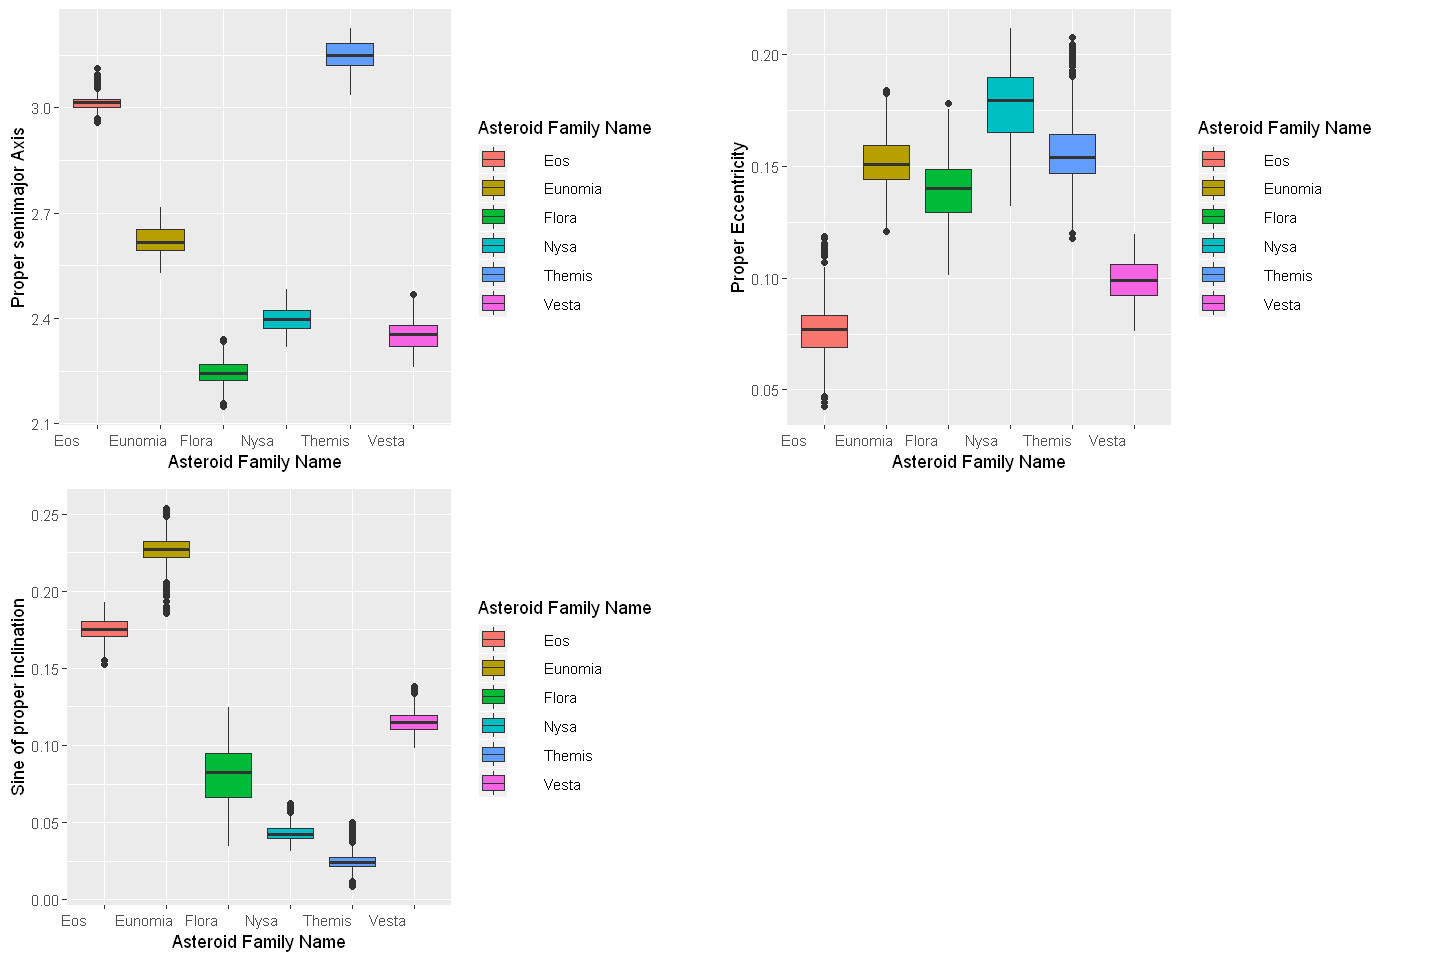

In [8]:
####Box Plot to get idea of differences in families
require(gridExtra)
library(ggplot2)

options(repr.plot.width=12, repr.plot.height=8)
plot1 <- ggplot(df.top.six.complete, aes(x = df.top.six.complete$Family_Name , y = df.top.six.complete$Proper_semimajor_axis, fill = df.top.six.complete$Family_Name)) + 
  geom_boxplot()+xlab("Asteroid Family Name")+ylab("Proper semimajor Axis")+ labs(fill="Asteroid Family Name") 
plot2 <- ggplot(df.top.six.complete, aes(x = df.top.six.complete$Family_Name , y = df.top.six.complete$Proper_eccentricity, fill = df.top.six.complete$Family_Name)) + 
  geom_boxplot()+xlab("Asteroid Family Name")+ylab("Proper Eccentricity")+ labs(fill="Asteroid Family Name") 
plot3 <- ggplot(df.top.six.complete, aes(x = df.top.six.complete$Family_Name , y = df.top.six.complete$Sine_of_proper_inclination, fill = df.top.six.complete$Family_Name)) + 
  geom_boxplot()+xlab("Asteroid Family Name")+ylab("Sine of proper inclination")+ labs(fill="Asteroid Family Name")   
grid.arrange(plot1, plot2, plot3 , ncol=2 , nrow =2)

### Brief steps to K-Means clustering algorithm 

Before diving into K-Means let us perform a quick summary of the steps involved:-<br>
 1) Randomly initialize the centroids.<br>
    There number of centroids will be equal to the number of clusters.<br>
    
 2) Take an observation and calculate its distance to all of the centroids.<br>
 
 3) Assign the observation to the centroid group closest to it.<br>
    The observation now becomes a part of that cluster.<br>
    
 4) Recompute the centroids.<br>
 
 Steps 1-4 are repeated iteratively till some stopping criteris i.e. no data points change clusters or the distance between the previous and newly recomputed centroids do not change.<br>
    
 



We finally start the clustering.

In [9]:
## Begining  k means clustering in R
set.seed(40)
clusters <- kmeans(df.top.six.complete[,3:5], 6)
df.top.six.complete$cluster.num <- as.factor(clusters$cluster)
str(clusters)

List of 9
 $ cluster     : Named int [1:3523] 6 3 2 1 3 6 1 5 2 1 ...
  ..- attr(*, "names")= chr [1:3523] "3" "7" "14" "23" ...
 $ centers     : num [1:6, 1:3] 3.15 2.66 2.25 3.02 2.6 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:6] "1" "2" "3" "4" ...
  .. ..$ : chr [1:3] "Proper_semimajor_axis" "Proper_eccentricity" "Sine_of_proper_inclination"
 $ totss       : num 464
 $ withinss    : num [1:6] 1.001 0.11 2.304 0.393 0.253 ...
 $ tot.withinss: num 7.15
 $ betweenss   : num 457
 $ size        : int [1:6] 578 195 1126 524 327 773
 $ iter        : int 2
 $ ifault      : int 0
 - attr(*, "class")= chr "kmeans"


In [10]:
##quickly display head and table
df.table <- as.data.frame(table(df.top.six.complete$cluster.num))
colnames(df.table)<-c("Cluster Number","Count")
df.table

Cluster Number,Count
1,578
2,195
3,1126
4,524
5,327
6,773


In [11]:
df.test<- as.data.frame(table(df.top.six.complete$Family_Name,df.top.six.complete$cluster.num)) 
df.test <- df.test[df.test$Var1 %in%  df.top.six$Family_Name ,]
df.test$Var2 <- factor(df.test$Var2)

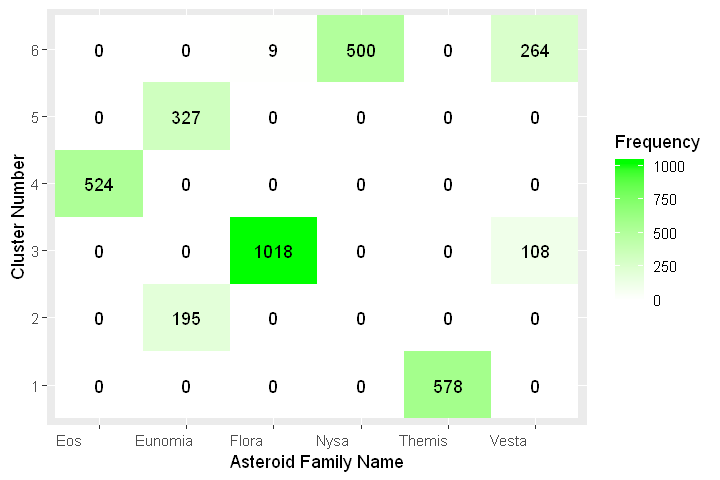

In [12]:
## plot data
options(repr.plot.width=6, repr.plot.height=4)

ggplot(df.test, aes(df.test$Var1, df.test$Var2)) +
    geom_tile(aes(fill = df.test$Freq)) + 
    geom_text(aes(label = round(df.test$Freq, 1))) +
    scale_fill_gradient(low = "white", high = "green") + 
    labs(x = "Asteroid Family Name" , y = "Cluster Number" , fill = "Frequency")

From the confusion matrix we can draw the following conclusions:-<br>
 
   1) Eos is correctly classified in Cluster 4.<br>
   2) Eunomia is split across 2 Clusters 2&5.<br>
   3) Flora is classified in cluster 3.<br>
   4) Nysa is again correctly classified altogether in cluster 6.<br>
   5) Themis is clssified in cluster 1.<br>
   6) Vesta is not getting correctly classified.It is mixed with Flora and Nysa.<br>
   
   


### The Elbow Method for optimum number of clusters.

Here we will explore the elbow method to decide on the optimum number of clusters.<br>
As will be seen in the graph the parameter tot.withinss is high dropping of rapidly as the number of clusters increase.<br>
The inflection point where the drop decreases gives us the optimum number of clusters.<br>




In [13]:
####  Use Elbow method to get optimum number of clusters
set.seed(40)
kmean_withinss <- function(k) {
    clusters <- kmeans(df.top.six.complete[,3:5], k)
    return (clusters$tot.withinss)
}
# Set maximum cluster 
max_k <-10
# Run algorithm over a range of k 
wss <- sapply(1:max_k, kmean_withinss)
# Create a data frame to plot the graph
elbow <-data.frame(1:max_k, wss)

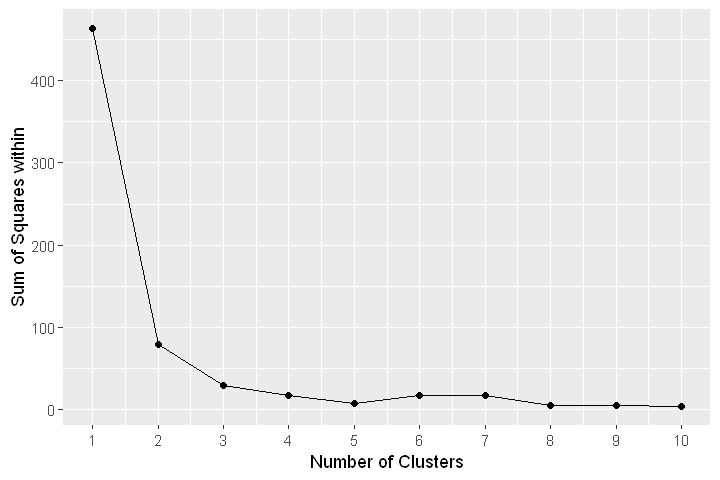

In [14]:
# Plot the graph with gglopt
options(repr.plot.width=6, repr.plot.height=4)

ggplot(elbow, aes(x = X1.max_k, y = wss)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = seq(1, 20, by = 1))+
     labs(y = "Sum of Squares within" , x = "Number of Clusters")

Here we see 5 would br the optmimum number of clusters.<br>

However there is a slight increase between 5 & 8.<br>
Lets perform the clustering and plot confusion matrix for these cluster numbers.<br>

In [15]:
### Exploring options between 5 & 8
## Begining  k means clustering in R

#### 5 Clusters 
set.seed(40)
clusters <- kmeans(df.top.six.complete[,3:5], 5)
df.top.six.complete$cluster.num <- as.factor(clusters$cluster)

df.test5 <- as.data.frame(table(df.top.six.complete$Family_Name,df.top.six.complete$cluster.num)) 
df.test5 <- df.test5[df.test5$Var1 %in%  df.top.six$Family_Name ,]
df.test5$Var2 <- factor(df.test5$Var2)

#### 6 Clusters 
set.seed(40)
clusters <- kmeans(df.top.six.complete[,3:5], 6)
df.top.six.complete$cluster.num <- as.factor(clusters$cluster)

df.test6<- as.data.frame(table(df.top.six.complete$Family_Name,df.top.six.complete$cluster.num)) 
df.test6 <- df.test6[df.test6$Var1 %in%  df.top.six$Family_Name ,]
df.test6$Var2 <- factor(df.test6$Var2)

#### 7 Clusters 
set.seed(40)
clusters <- kmeans(df.top.six.complete[,3:5], 7)
df.top.six.complete$cluster.num <- as.factor(clusters$cluster)

df.test7 <- as.data.frame(table(df.top.six.complete$Family_Name,df.top.six.complete$cluster.num)) 
df.test7 <- df.test7[df.test7$Var1 %in%  df.top.six$Family_Name ,]
df.test7$Var2 <- factor(df.test7$Var2)


#### 8 Clusters 
set.seed(40)
clusters <- kmeans(df.top.six.complete[,3:5], 8)
df.top.six.complete$cluster.num <- as.factor(clusters$cluster)

df.test8<- as.data.frame(table(df.top.six.complete$Family_Name,df.top.six.complete$cluster.num)) 
df.test8 <- df.test8[df.test8$Var1 %in%  df.top.six$Family_Name ,]
df.test8$Var2 <- factor(df.test8$Var2)



In [16]:
df.test5["Number_of_Clusters"] = 5
df.test6["Number_of_Clusters"] = 6
df.test7["Number_of_Clusters"] = 7
df.test8["Number_of_Clusters"] = 8
df.test.total <- rbind(df.test5,df.test6,df.test7,df.test8)
df.test.total$Var2 <- factor(df.test.total$Var2)

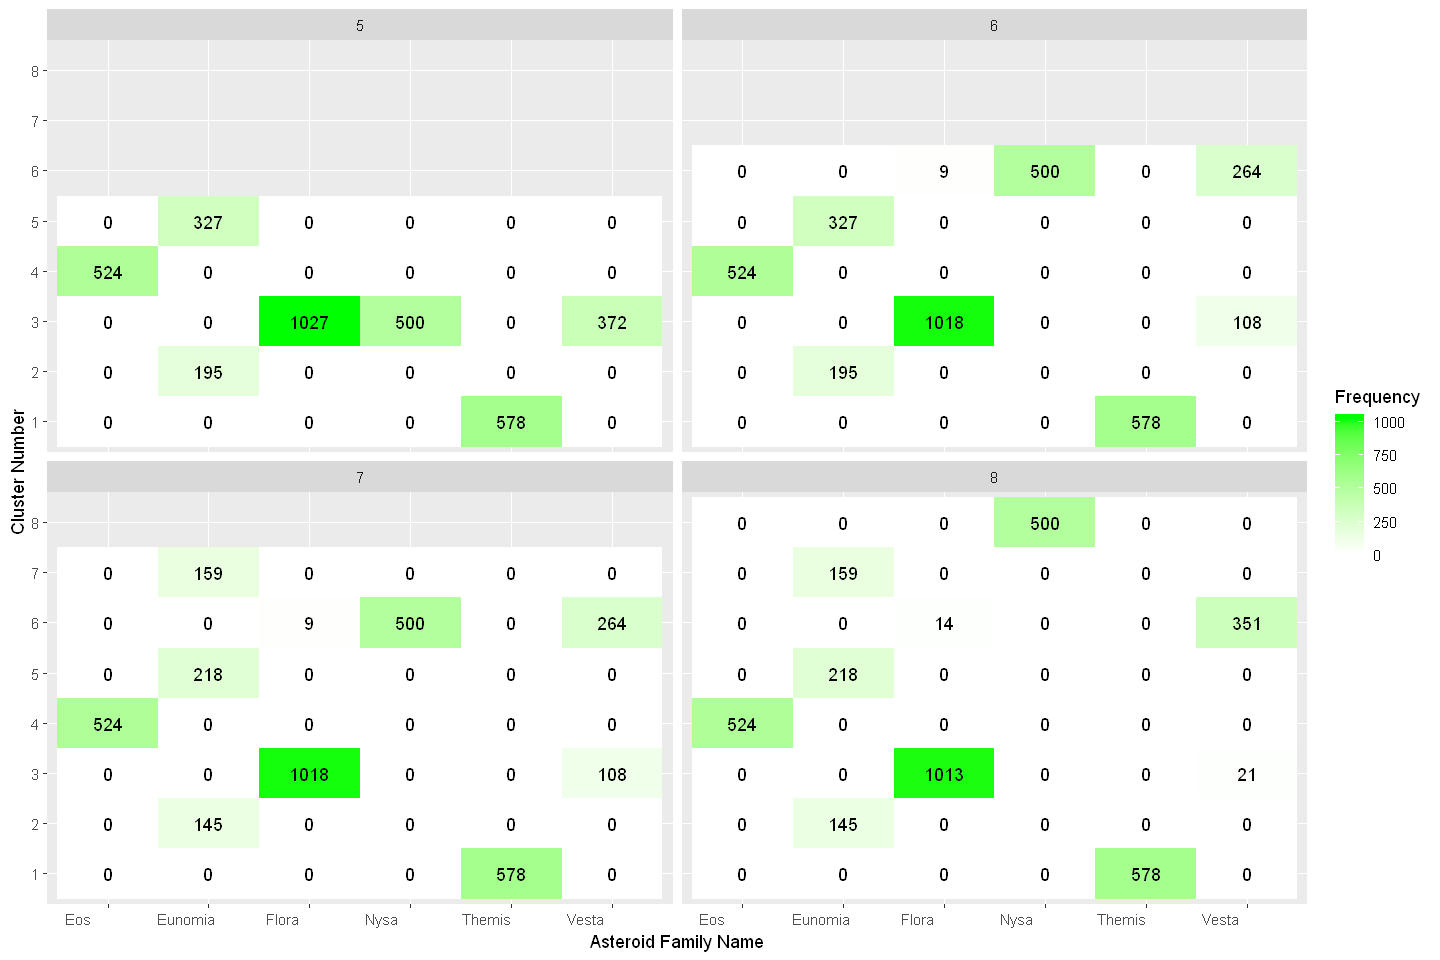

In [17]:
####Box Plot to get idea of differences in families
options(repr.plot.width=12, repr.plot.height=8)

ggplot(df.test.total, aes(df.test.total$Var1, df.test.total$Var2)) +
    geom_tile(aes(fill = df.test.total$Freq)) + 
    geom_text(aes(label = round(df.test.total$Freq, 1))) +
    scale_fill_gradient(low = "white", high = "green") +
    #facet_grid(rows = df.test.total$Number_of_Clusters) +
    facet_wrap(df.test.total$Number_of_Clusters, ncol = 2)+
     labs(x = "Asteroid Family Name" , y = "Cluster Number" , fill = "Frequency")

As shown in the above matrix Vesta finally gets its own cluster when the number of clusters used is 8.<br>
This could be the reason why the Elbow graph again drops of when the number of clusters is 8.<br>
The flip side is Eunomia is now split across 3 different clusters